## ANN Classification Weighted Loss - tensorflow

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Input
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [5]:
# Load dataset
data = pd.read_csv("fraudTest.csv", index_col=0)

data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [6]:
# Drop columns with too many categories or not useful
data = data.drop(columns=[
    "cc_num", "first", "last", "street",
    "trans_num", "trans_date_trans_time",
    "job", "merchant", "zip", "dob", "city"
])

In [7]:
# Label encode gender
gender_le = LabelEncoder()
data['gender'] = gender_le.fit_transform(data['gender'])

# One-hot encode 'category' and 'state'
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
cat_features = ['category', 'state']
ohe_encoded = ohe.fit_transform(data[cat_features])

ohe_df = pd.DataFrame(ohe_encoded,
                      columns=ohe.get_feature_names_out(cat_features),
                      index=data.index)

df = pd.concat([data.drop(columns=cat_features), ohe_df], axis=1)

In [8]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

num_cols = ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Convert to numpy for TensorFlow
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_train_np = y_train.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

In [9]:
# Compute class weights to handle imbalance
# Equivalent of pos_weight in PyTorch's BCEWithLogitsLoss
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
pos_weight = neg / pos

class_weight = {0: 1.0, 1: float(pos_weight)}

print(f"Non-fraud: {neg} | Fraud: {pos} | pos_weight: {pos_weight:.2f}")
print(f"class_weight: {class_weight}")

Non-fraud: 442859 | Fraud: 1716 | pos_weight: 258.08
class_weight: {0: 1.0, 1: 258.0763403263403}


In [10]:
inp_dim = X_train_np.shape[1]

model = tf.keras.Sequential([
    Input(shape=(inp_dim,)),
    Dense(128),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.3),
    Dense(64),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.3),
    Dense(1) 
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,409 (68.00 KB)

 Trainable params: 17,409 (68.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# from_logits=True is the TF equivalent of BCEWithLogitsLoss in PyTorch
# It applies Sigmoid internally — numerically more stable than adding Sigmoid to the model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

In [ ]:
history = model.fit(
    X_train_np, y_train_np,
    epochs=50,
    batch_size=256,
    validation_data=(X_test_np, y_test_np),
    class_weight=class_weight,
    verbose=1
)

Epoch 1/50
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.8707 - val_loss: 0.2979
Epoch 2/50
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5993 - val_loss: 0.2092
Epoch 3/50
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.5157 - val_loss: 0.2012
Epoch 4/50
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.4685 - val_loss: 0.1612
Epoch 5/50
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.4423 - val_loss: 0.2192
Epoch 6/50
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.3973 - val_loss: 0.1818
Epoch 7/50
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.3495 - val_loss: 0.1743
Epoch 8/50
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3381 - val_loss: 0.1528
Epoch 9/50
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3034 - val_loss: 0.1376
Epoch 10/50
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3058 - val_loss: 0.1361
Epoch 11/50
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.2803 - val_loss: 0.1711
Epoch 12/50
1737/1737 ━━━━━

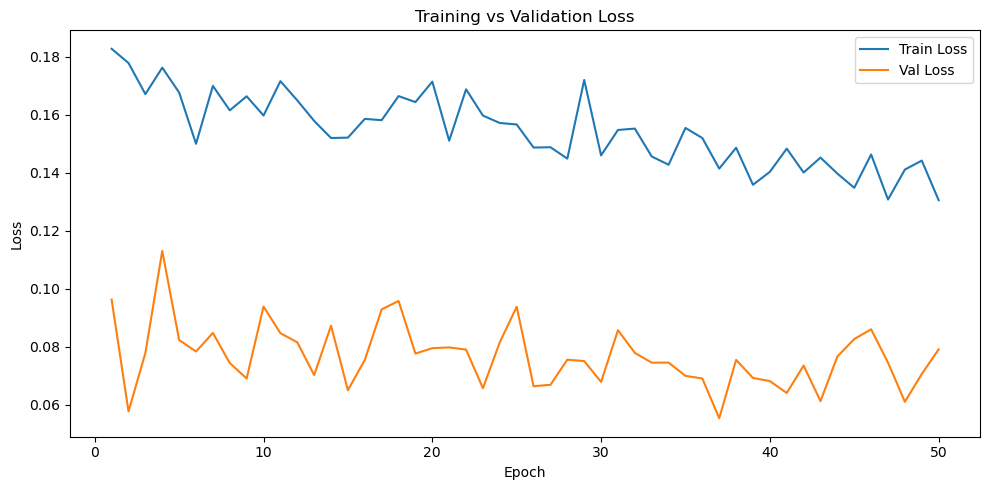

In [ ]:
epochs_run = len(history.history['loss'])

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs_run + 1), history.history['loss'], label='Train Loss')
plt.plot(range(1, epochs_run + 1), history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

3474/3474 ━━━━━━━━━━━━━━━━━━━━ 3s 841us/step


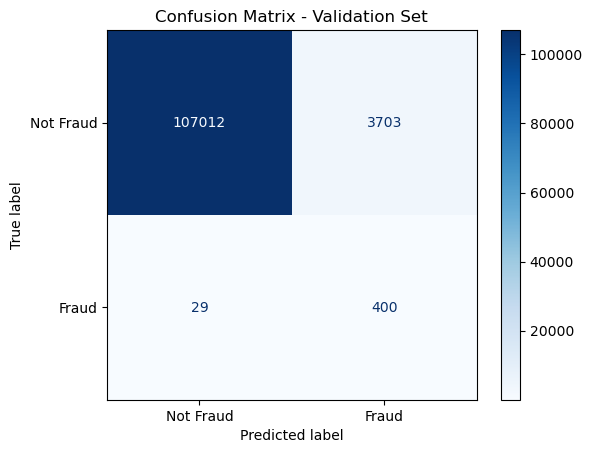

              precision    recall  f1-score   support

   Not Fraud       1.00      0.97      0.98    110715
       Fraud       0.10      0.93      0.18       429

    accuracy                           0.97    111144
   macro avg       0.55      0.95      0.58    111144
weighted avg       1.00      0.97      0.98    111144



In [ ]:
# Model outputs logits — apply Sigmoid manually at inference
logits = model.predict(X_test_np)
y_pred_probs = tf.sigmoid(logits).numpy().squeeze()
y_pred = (y_pred_probs >= 0.5).astype(int)
y_true = y_test_np.astype(int)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Not Fraud', 'Fraud']))